### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [4]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [5]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [6]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)
The scikit-learn version is 0.24.2.


In [7]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here


In [8]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [9]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [10]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';');

print("General Demographics Data Structure:", azdias.shape)# Prints number of rows and columns
print("First 5 Rows of General Demographics Data:") # view first few rows
azdias.head(5)

# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

General Demographics Data Structure: (891221, 85)
First 5 Rows of General Demographics Data:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [11]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';');

print("Feature Summary Data Structure", feat_info.shape)
print("First 5 Rows of Feature Summary Data:")
feat_info.head(5)


Feature Summary Data Structure (85, 4)
First 5 Rows of Feature Summary Data:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

# Identify missing/unknown values
num_missing = azdias.isnull().sum()
display(num_missing.head(10))
print("The total number of missing or unkown values is", num_missing.sum())


AGER_TYP                    0
ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
dtype: int64

The total number of missing or unkown values is 4896838


In [13]:
#identify the encoded values
display(feat_info['missing_or_unknown'].head(10))

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
5        [-1]
6        [-1]
7        [-1]
8        [-1]
9        [-1]
Name: missing_or_unknown, dtype: object

In [14]:
#import regular expression
import re

#convert encoded values to Nans
for i in range(len(feat_info)):
    # using regex to extract the digits
    missing_data = re.sub('[\[|\]]', '',feat_info.iloc[i]['missing_or_unknown']).split(',')
    # return the digit values for int strings 
    if missing_data != ['']:
        missing_data = [np.int64(data) if (data!='X' and data!='XX') else data for data in missing_data]
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_data}, np.nan)

In [15]:
# Verify the total missing values after conversion
num_missing = azdias.isnull().sum()
print("Missing values after conversion:")
display(num_missing.head(10))
print("The total number of missing or unknown values after conversion is:", num_missing.sum())

Missing values after conversion:


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
dtype: int64

The total number of missing or unknown values after conversion is: 8373929


In [16]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
def convert_string_list_col(col):
    """
    converts a string into a list
    """
    updated_list = list()
    for items in col:
        updated_list.append(items[1:-1].split(","))
    return updated_list

string_list = convert_string_list_col(feat_info['missing_or_unknown'])


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

num_missing_columns = azdias.isnull().sum()
display(num_missing_columns.head())
print(num_missing_columns.describe())
print("The total number of Data Missing:", num_missing_columns.sum())

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64
The total number of Data Missing: 8373929


In [19]:
# Calculate the percentage of missing values for each column
missing_percentage = azdias.isnull().mean() * 100

# Display the top 10 columns with the highest percentage of missing values
display(missing_percentage.sort_values(ascending=False).head(10))

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
dtype: float64

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
MIN_GEBAEUDEJAHR          93148
OST_WEST

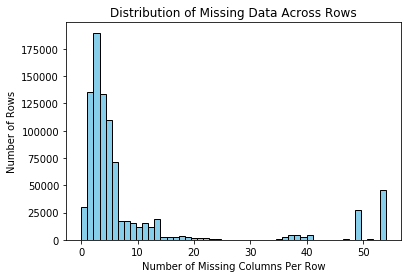

In [20]:
# Investigate patterns in the amount of missing data in each column.

# Step 1: Create a mask of columns with missing data
missing_columns = azdias.columns[azdias.isnull().any()]

# Step 2: Display the missing data for these columns
missing_data = azdias[missing_columns].isnull().sum()
display(missing_data)

# Step 3: Visualize missing data pattern for each row 
azdias[missing_columns].isnull().sum(axis=1).plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Missing Data Across Rows')
plt.xlabel('Number of Missing Columns Per Row')
plt.ylabel('Number of Rows')
plt.show()

# Step 4: Look for any patterns in the missing data
# check for any possible correlation between missing data in different columns
# Create a correlation matrix for missing data pattern
missing_corr = azdias[missing_columns].isnull().astype(int).corr()

In [21]:
#double check rows and columns to properly adjust the number of rows and columns for boxplot
azdias.shape 

(891221, 85)

Text(0,0.5,'Proportion of Null Values')

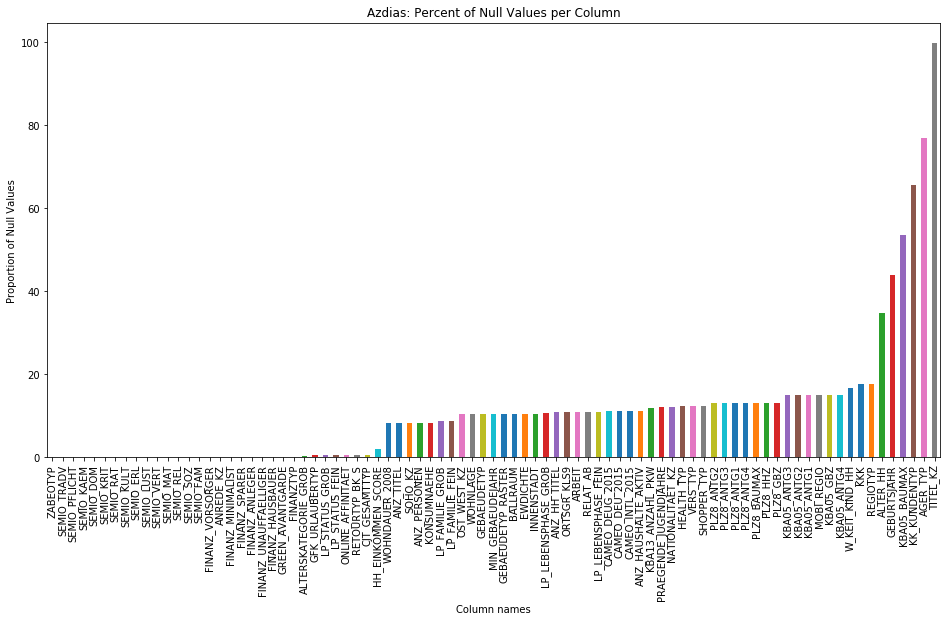

In [22]:
missing_percentage.sort_values().plot(kind="bar", figsize=(16,8))
plt.title("Azdias: Percent of Null Values per Column")
plt.xlabel("Column names")
plt.ylabel("Proportion of Null Values")

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# List of columns to drop based on high proportion of missing data
columns_to_drop = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']

# Drop the columns from the dataset
azdias_cleaned = azdias.drop(columns=columns_to_drop)

In [24]:
# Check the shape of the dataset after dropping the columns

azdias.shape
azdias_cleaned.shape

(891221, 79)

In [25]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Columns Removed:**

The following columns were removed based on high missing data:

ALTER_HH: Household age group
GEBURTSJAHR: Year of birth
KBA05_BAUMAX: Maximum tree age 
KK_KUNDENTYP: Customer type
AGER_TYP: Age group
TITEL_KZ: Title indicator 

**Missing data assesment**

Initiall I assessed the missing data percentage in each column and identified that certain columns had a high proportion of missing values (over 20%). By setting a threshold and removing the columns that had missing data above 20-25%, I've significantly reduced the number of columns that could potentially introduce noise into further analysis.

**Patterns in missing values?**

No obvious correlation: Without further analysis, it's difficult to pinpoint any correlation between the missing values in these columns. However we could eventually perform correlation analysis on missing data to see if missing values in one column correlates with others. This might reveal if certain rows or subsets of data tend to have missing values across the same columns.


***

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?

# Calculate the number of missing values for each row
missing_per_row = azdias_cleaned.isnull().sum(axis=1)

# Display the first few rows of the result
missing_per_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [27]:
#calculate the proportion of missing data in each row
missing_percentage_per_row = azdias_cleaned.isnull().mean(axis=1) * 100

missing_percentage_per_row.describe()

count    891221.000000
mean          7.151764
std          16.752768
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
dtype: float64

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Define the threshold for missing data percentage
threshold = 25

# Create subsets of rows with missing data above and below the threshold
rows_above_threshold = azdias_cleaned[missing_percentage_per_row > threshold]
rows_below_threshold = azdias_cleaned[missing_percentage_per_row <= threshold]

# Check the number of rows in each subset
print(f"Rows with more than {threshold}% missing data: {len(rows_above_threshold)}")
print(f"Rows with less than or equal to {threshold}% missing data: {len(rows_below_threshold)}")

Rows with more than 25% missing data: 94144
Rows with less than or equal to 25% missing data: 797077


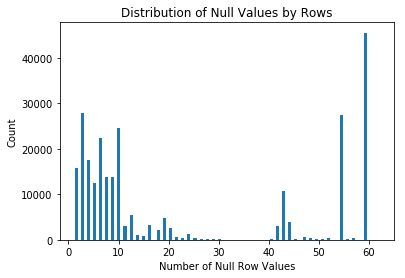

In [29]:
# How much data is missing in each row of the dataset?
plt.hist(missing_percentage_per_row[missing_percentage_per_row != 0], bins=100)
plt.title('Distribution of Null Values by Rows')
plt.ylabel('Count')
plt.xlabel('Number of Null Row Values')
plt.show()

In [30]:
# Calculate the number of missing values for each column
num_col_null_azdias = azdias_cleaned.isnull().sum()

# Sorting the columns by missing value counts
num_col_null_azdias = num_col_null_azdias.sort_values()  

Columns to compare:  ['ZABEOTYP', 'FINANZ_VORSORGER', 'SEMIO_TRADV', 'SEMIO_ERL', 'ALTERSKATEGORIE_GROB']


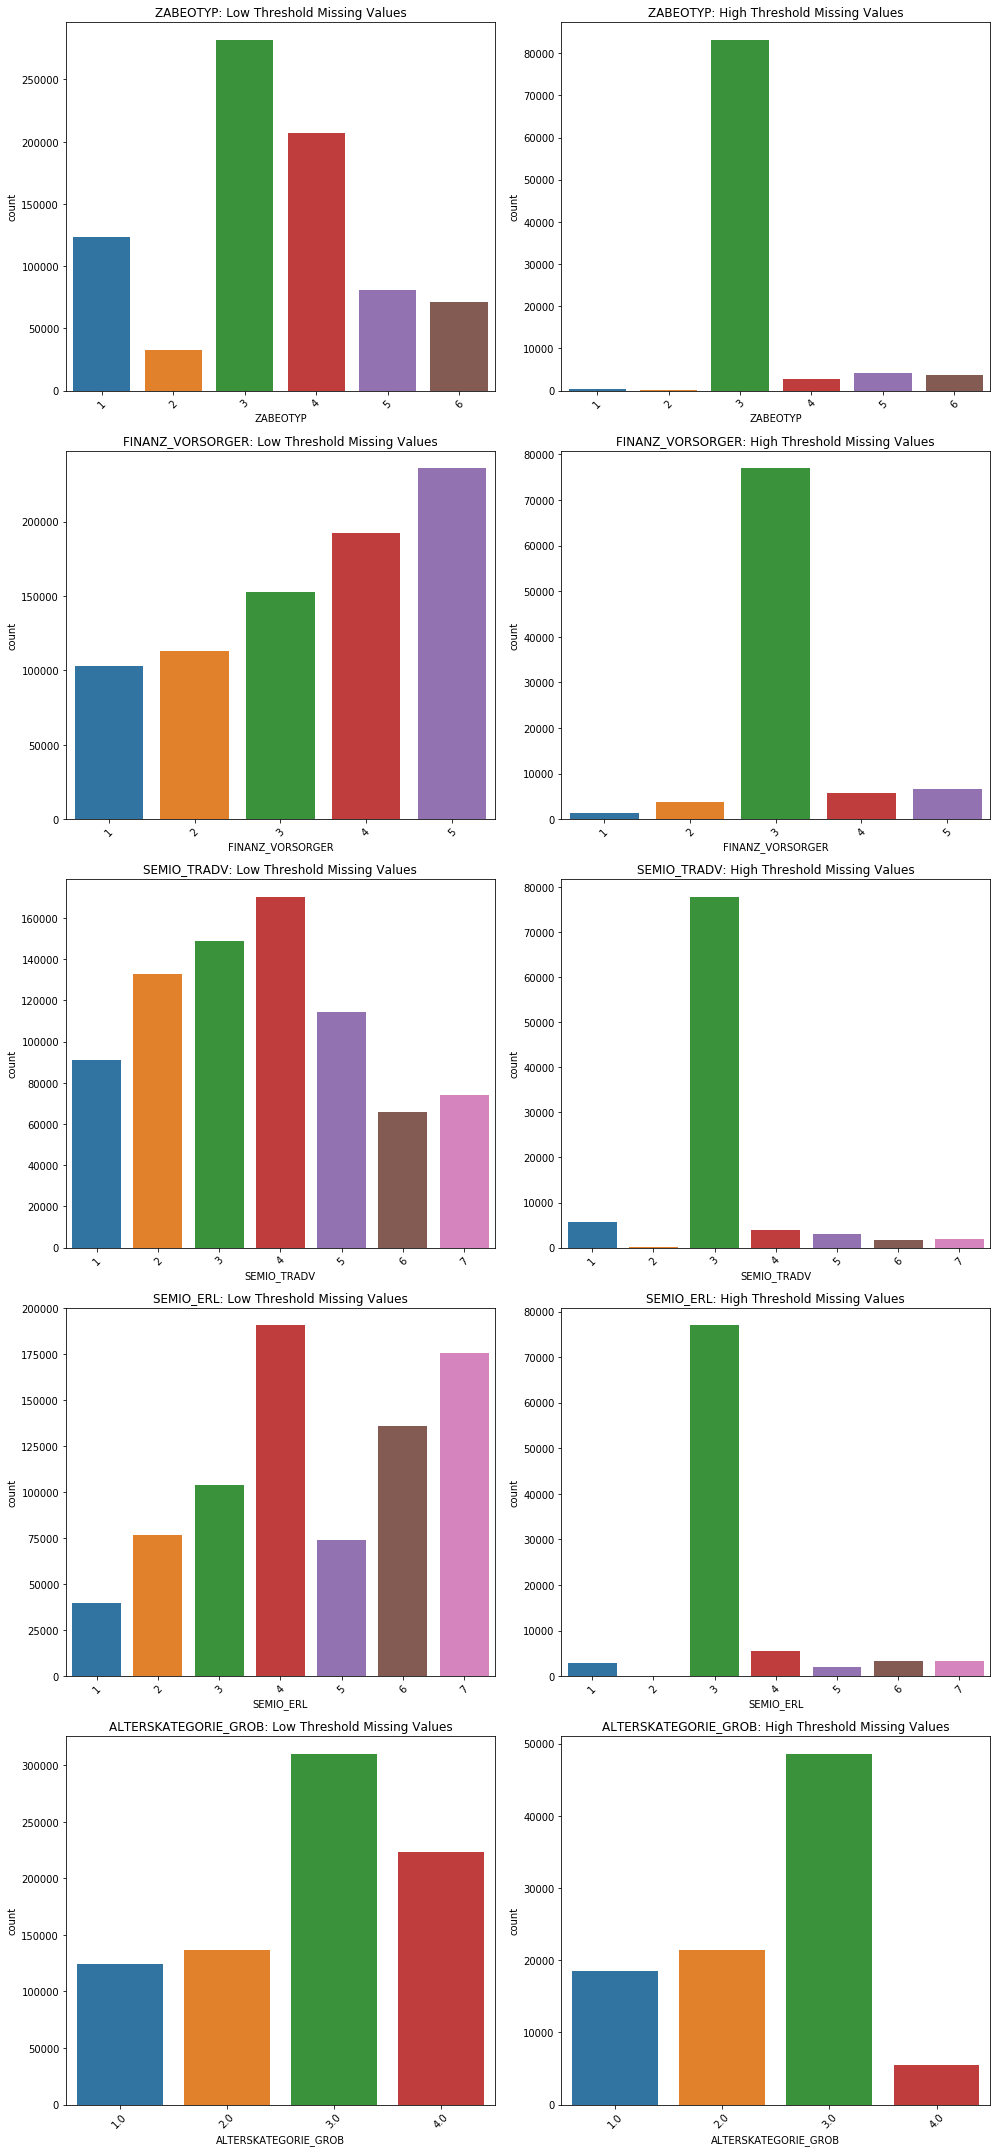

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#double check the column list
col_compare_notnull = num_col_null_azdias.sort_values()[:30:6].index.tolist()

def compare_dist_columns(columns):
  
    print('Columns to compare: ', columns)

    fig, ax = plt.subplots(nrows=len(columns), ncols=2, figsize=(14, len(columns) * 6))
    
    # Loop through each column to generate subplots
    for indx, column in enumerate(columns):
        # Check for missing values before plotting
        if column in rows_below_threshold.columns and column in rows_above_threshold.columns:
            # Plot distribution of column for rows below the threshold
            sns.countplot(data=rows_below_threshold, x=column, ax=ax[indx][0])
            ax[indx][0].set_title(f"{column}: Low Threshold Missing Values")
            ax[indx][0].set_xticklabels(ax[indx][0].get_xticklabels(), rotation=45)

            # Plot distribution of column for rows above the threshold
            sns.countplot(data=rows_above_threshold, x=column, ax=ax[indx][1])
            ax[indx][1].set_title(f"{column}: High Threshold Missing Values")
            ax[indx][1].set_xticklabels(ax[indx][1].get_xticklabels(), rotation=45)
        
        else:
            print(f"Column '{column}' is missing in one of the datasets.")
    
    # Adjust layout to prevent overlapping
    fig.tight_layout()
    plt.show()

# Run the function with the list of columns
compare_dist_columns(col_compare_notnull)

In [32]:
# check no_null_no_outlier.isnull().sum(axis=1)
no_null_no_outlier = rows_below_threshold.fillna(rows_below_threshold.mode().iloc[0])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer**

The distribution of missing data between the datasets- those with few or no missing values and those with high amounts of missing values—is significantly different, as shown in the graphs above. This suggests that further analysis should focus on the subset with fewer missing values. In most cases, data with a high proportion of missing values tends to differ qualitatively from data with fewer missing values. Using the data with many missing values could lead to inaccurate predictions, so it's advisable to prioritize the cleaner subset for analysis.

***

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [34]:
#Counts of datatypes
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [35]:
feat_sum = feat_info
# How many features are there of each data type?
feat_info = feat_sum[feat_sum.attribute.isin(no_null_no_outlier.columns)]
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [36]:
categorical = feat_sum[feat_sum.type=="categorical"]
cat_binary = []
cat_multi_level = []

for col in categorical.attribute:
    if col in no_null_no_outlier.columns:
        if no_null_no_outlier[col].nunique() == 2:
            cat_binary.append(col)
        else:
            cat_multi_level.append(col)
    else:
        continue


for col in cat_binary:
    print(no_null_no_outlier[col].value_counts())

2    415578
1    381499
Name: ANREDE_KZ, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
2.0    430454
1.0    366623
Name: VERS_TYP, dtype: int64
W    628695
O    168382
Name: OST_WEST_KZ, dtype: int64


In [37]:
# Separate the columns based on their data type
ordinal_features = feat_info[feat_info['type'] == 'ordinal'].index.tolist()
categorical_features = feat_info[feat_info['type'] == 'categorical'].index.tolist()
mixed_features = feat_info[feat_info['type'] == 'mixed'].index.tolist()
numeric_features = feat_info[feat_info['type'] == 'numeric'].index.tolist()
interval_features = feat_info[feat_info['type'] == 'interval'].index.tolist()

# Print to verify the column types
print(f"Ordinal Features: {ordinal_features}")
print(f"Categorical Features: {categorical_features}")
print(f"Mixed Features: {mixed_features}")
print(f"Numeric Features: {numeric_features}")
print(f"Interval Features: {interval_features}")

Ordinal Features: [1, 4, 5, 6, 7, 8, 9, 14, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 46, 48, 49, 53, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84]
Categorical Features: [2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 41, 42, 52, 55, 57, 58]
Mixed Features: [15, 16, 22, 56, 59, 79]
Numeric Features: [44, 45, 50, 51, 54, 74]
Interval Features: []


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_sum[feat_sum.type=="categorical"]
cat_binary = []
cat_multi_level = []

for col in categorical.attribute:
    if col in no_null_no_outlier.columns:
        if no_null_no_outlier[col].nunique() == 2:
            cat_binary.append(col)
        else:
            cat_multi_level.append(col)
    else:
        continue


for col in cat_binary:
    print(no_null_no_outlier[col].value_counts())

2    415578
1    381499
Name: ANREDE_KZ, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
2.0    430454
1.0    366623
Name: VERS_TYP, dtype: int64
W    628695
O    168382
Name: OST_WEST_KZ, dtype: int64


In [39]:
# Re-encode categorical variable(s) to be kept in the analysis.

def reencode_categorical_variables(df):
    categorical = feat_sum[feat_sum.type=="categorical"]
    cat_binary = []
    cat_multi_level = []

    for col in categorical.attribute:
        if col in no_null_no_outlier.columns:
            if no_null_no_outlier[col].nunique() == 2:
                cat_binary.append(col)
            else:
                cat_multi_level.append(col)
        else:
            continue

    df["ANREDE_KZ"].replace({2:0, 1:1}, inplace = True)
    df["SOHO_KZ"].replace({0.0:0,1.0:1}, inplace = True)
    df["VERS_TYP"].replace({2.0:0,1.0:1}, inplace = True)
    df["OST_WEST_KZ"].replace({'W':0,'O':1}, inplace=True)
    df = pd.get_dummies(data=df,columns=cat_multi_level)
    return df

no_null_no_outlier = reencode_categorical_variables(no_null_no_outlier)
no_null_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 194 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_9E
dtypes: float64(42), int64(23), object(1), uint8(128)
memory usage: 504.7+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features


To prepare the categorical features for analysis:


   * Binary Features:

        * I identified binary features such as ANREDE_KZ, SOHO_KZ, VERS_TYP, and OST_WEST_KZ.
        * These features were encoded manually for clarity and consistency. For instance, ANREDE_KZ was mapped as {2: 0, 1: 1}, and OST_WEST_KZ was mapped as {'W': 0, 'O': 1} to align with a numerical representation.


   * Multi-Level Features:

    Multi-level categorical features were re-encoded using pd.get_dummies(). This method converts each category into separate binary columns, ensuring no ordinal assumption is made about the categories. While this increases the number of features, it avoids introducing bias from incorrect ordering assumptions.


   * Features Dropped:

    Some categorical features were excluded because they were irrelevant, too sparse, or unnecessary for the analysis. These decisions were based on domain knowledge and preliminary data exploration.


   * Handling Mixed Features:

    Mixed-type features were identified but not processed at this step. They will be addressed later to avoid conflating different data types prematurely.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

MAP_DECADE = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 
              11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
MAP_MOVEMENT = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 
                10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0}

def add_decade_movement_feat(df):
    """
    Replace/add new features based on "PRAEGENDE_JUGENDJAHRE".
    
    Args:
        df (pd.DataFrame): The data frame containing the column.

    Returns:
        pd.DataFrame: Updated data frame with new features.
    """
    # Create new columns for DECADE and MOVEMENT
    df["DECADE"] = df["PRAEGENDE_JUGENDJAHRE"]
    df["MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"]

    # Map the values using pre-defined dictionaries
    df["DECADE"].replace(MAP_DECADE, inplace=True)
    df["MOVEMENT"].replace(MAP_MOVEMENT, inplace=True)

    # Drop the original column to avoid redundancy
    df.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

    return df

# Apply the transformation
no_null_no_outlier = add_decade_movement_feat(no_null_no_outlier)

In [41]:
print(no_null_no_outlier[["DECADE", "MOVEMENT"]].head())

   DECADE  MOVEMENT
1     6.0       1.0
2     6.0       0.0
3     4.0       1.0
4     4.0       1.0
5     2.0       1.0


In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

MAP_WEALTH = {
    '11': 1, '12': 1, '13': 1, '14': 1, '15': 1,
    '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
    '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,
    '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
    '51': 5, '52': 5, '53': 5, '54': 5, '55': 5
}
MAP_LIFE_TYPOLOGY = {
    '11': 1, '12': 2, '13': 3, '14': 4, '15': 5,
    '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
    '31': 1, '32': 2, '33': 4, '34': 4, '35': 5,
    '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
    '51': 1, '52': 2, '53': 3, '54': 4, '55': 5
}

def add_wealth_life_feat(df):
    """
    Replace/add new features based on "CAMEO_INTL_2015".
    
    Args:
        df (pd.DataFrame): The data frame containing the column.

    Returns:
        pd.DataFrame: Updated data frame with new features.
    """
    # Create new columns for WEALTH and LIFE_TYPOLGY
    df["WEALTH"] = df["CAMEO_INTL_2015"]
    df["LIFE_TYPOLGY"] = df["CAMEO_INTL_2015"]

    # Map the values using pre-defined dictionaries
    df["WEALTH"].replace(MAP_WEALTH, inplace=True)
    df["LIFE_TYPOLGY"].replace(MAP_LIFE_TYPOLOGY, inplace=True)

    # Drop the original column to avoid redundancy
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)

    return df

# Apply the transformation
no_null_no_outlier = add_wealth_life_feat(no_null_no_outlier)

In [43]:
print(no_null_no_outlier[["WEALTH", "LIFE_TYPOLGY"]].head())

   WEALTH  LIFE_TYPOLGY
1       5             1
2       2             4
3       1             2
4       4             3
5       5             4


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

***

To address the mixed-value features in the dataset, I focused on engineering new variables from two key columns, "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015", as they provided rich information on customer characteristics:

**"PRAEGENDE_JUGENDJAHRE":**

This column combines information about generational cohorts and their social movements. Using the mappings provided in the Data_Dictionary.md file, I created two new features:

   * "Decade": A numerical variable representing the generational cohort based on the decade of socialization.
    * "Movement": A binary variable indicating whether the generation leaned toward avant-garde (1) or mainstream (0) values. These engineered features are valuable as they reflect how generational differences influence customer preferences and behaviors.
    
    
**"CAMEO_INTL_2015":**

This column encodes wealth and life-stage information. Based on the mappings from the Data_Dictionary.md file, I created two new features:

   * "Wealth": An ordinal variable categorizing customers by their relative wealth levels.
   * "Life Typology": An ordinal variable representing the customer’s stage in life, such as young single, family-oriented, or senior.These features are critical for segmentation, as wealth and lifestyle significantly influence purchasing behaviors and service needs.
    
    
By engineering these new features, I retained the essential information from the mixed-type columns in a format suitable for analysis. These transformations enhance the dataset's utility for modeling and provide meaningful insights into customer behaviors.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Address other mixed type variables
def drop_mixed_variables(df, feat_info):
    mixed_variables = feat_sum[feat_sum['type'] == "mixed"]["attribute"]
    for feat in mixed_variables:
        if feat in df.columns:
            df.drop(feat, axis=1, inplace=True)
    return df

no_null_no_outlier = drop_mixed_variables(no_null_no_outlier, feat_sum)

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop columns with high missing values (>50% null)
missing_threshold = 0.5
missing_percent = no_null_no_outlier.isnull().mean()
cols_to_drop = missing_percent[missing_percent > missing_threshold].index
no_null_no_outlier.drop(cols_to_drop, axis=1, inplace=True)

In [46]:
# Check for reduncancy by remove highly correlated features
correlation_matrix = no_null_no_outlier.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
no_null_no_outlier.drop(highly_correlated, axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # Convert missing value codes to NaN (-1, -2, 0 for missing values)
    missing_value_codes = [-1, -2, 0]
    df.replace(missing_value_codes, np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    # Drop rows with too many missing values (more than 50%)
    missing_threshold = 0.5
    missing_percent = df.isnull().mean()
    cols_to_drop = missing_percent[missing_percent > missing_threshold].index
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    # Re-encode and engineer features for mixed-type columns
    df = add_decade_movement_feat(df)
    df = add_wealth_life_feat(df)
    
    # Remove highly correlated features (correlation > 0.95)
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
    df.drop(highly_correlated, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df

In [48]:
#apply the function to data
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')
df_prepared = clean_data(azdias_test)

#check the cleaned data
df_prepared.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_TYPOLGY
0,2,1,2.0,3,4,3,5,5,3,4,NaN,10.0,NaN,15.0,1.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,3.0,21.0,2.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,2.0,5,NaN,2.0,6.0,3.0,9.0,11.0,8.0,1.0,1992.0,W,4.0,8,8A,NaN,NaN,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5,1
2,3,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,3.0,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,1.0,5,17.0,1.0,4.0,3.0,9.0,10.0,1.0,5.0,1992.0,W,2.0,4,4C,1.0,3.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2,4
3,4,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,2.0,NaN,9.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,1.0,3,13.0,NaN,1.0,NaN,9.0,1.0,1.0,4.0,1997.0,W,7.0,2,2A,4.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1,2
4,3,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,3.0,32.0,3.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,2.0,4,20.0,4.0,5.0,2.0,9.0,3.0,1.0,4.0,1992.0,W,3.0,6,6B,1.0,4.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4,3


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

# handle missing values
fill_missing = SimpleImputer(strategy='most_frequent')
df_prepared = pd.DataFrame(fill_missing.fit_transform(df_prepared), columns=df_prepared.columns)


In [51]:
# Verify no missing values remain
print("Missing values per column after imputation:")
print(df_prepared.isnull().sum())

Missing values per column after imputation:
ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GEBURTSJAHR              0
GFK_URLAUBERTYP          0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_STATUS_FEIN           0
NATIONALITAET_KZ         0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SHOPPER_TYP              0
VERS_TYP                 0
ZABEOTYP                 0
ALTER_HH                 0
ANZ_PERSONE

In [52]:
# Convert columns to numeric where applicable
df_prepared = df_prepared.apply(pd.to_numeric, errors='ignore')

# Separate numeric and non-numeric columns again
numeric_cols = df_prepared.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = df_prepared.select_dtypes(exclude=['float64', 'int64']).columns

# Verify the separation
print("Numeric columns:", numeric_cols.tolist())
print("Non-numeric columns:", non_numeric_cols.tolist())

Numeric columns: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEI

In [53]:
# Apply feature scaling to the general population demographics data.

# Initialize the scaler
scaler = StandardScaler()

# Check if numeric_cols is not empty before scaling
if len(numeric_cols) > 0:
    # Apply scaling to numeric columns
    scaled_numeric = pd.DataFrame(
        scaler.fit_transform(df_prepared[numeric_cols]),
        columns=numeric_cols
    )
else:
    scaled_numeric = pd.DataFrame()

# Add non-numeric columns back to the scaled dataset
features_scaled = pd.concat([scaled_numeric, df_prepared[non_numeric_cols].reset_index(drop=True)], axis=1)

# Verify Scaling
print("First five rows of the scaled dataset:")
features_scaled.head(5)

First five rows of the scaled dataset:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,WEALTH,LIFE_TYPOLGY
0,-0.727373,-1.045218,-1.027618,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.105346,-0.004318,0.742875,0.938197,0.027784,-1.100125,-0.330667,1.107928,-0.999639,0.901553,1.374629,0.537487,-1.455284,0.316841,-0.819565,-0.538400,0.056863,1.221756,0.742018,0.839442,0.420264,-0.387544,-0.817336,0.864739,-0.267936,0.530355,-0.651197,-1.379075,0.873364,0.536436,-0.436907,-0.625846,-1.167350,-0.359845,-0.524581,-0.685572,-0.642721,-0.109875,0.771572,1.056974,0.209499,0.267123,0.254254,-1.118995,-1.379585,0.712197,1.689636,-0.260177,0.179355,0.124322,-0.587083,-0.572015,-0.317206,0.755697,-0.120115,-0.050006,0.994991,0.494701,W,8,6B,5,1
1,-1.663024,0.956738,0.858107,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-1.403804,2.173778,0.742875,0.938197,0.507572,-0.808354,-0.330667,-1.711653,0.541539,-0.142352,-0.119863,-0.539206,-1.455284,-1.166231,-1.372799,-0.538400,1.322441,-0.416882,1.298900,-0.240231,1.550121,1.369271,1.660725,0.864739,1.210585,0.530355,0.271316,1.079004,-0.822280,0.536436,0.231876,2.094122,-1.167350,-0.359845,0.018356,-0.685572,-0.642721,-1.739380,0.771572,-0.662553,1.768571,-0.872772,-0.863071,-1.118995,0.118043,-0.987654,0.615750,-0.260177,0.179355,0.124322,-0.587083,1.575581,0.640354,-0.263623,-0.120115,0.727181,0.994991,0.494701,W,8,8A,5,1
2,0.208278,0.956738,-0.399043,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,-1.403804,0.896963,0.742875,0.938197,-0.931792,-0.516582,-0.330667,-0.301862,0.027813,-1.708208,-0.618027,-0.539206,-0.011411,-0.177517,0.840140,-0.538400,0.056863,1.221756,1.298900,1.379279,-0.709593,-0.387544,0.421694,-1.156419,1.210585,0.229934,-0.651197,-0.150036,-0.822280,0.536436,0.164998,-0.625846,1.355387,-0.359845,-1.067517,-0.685572,1.677165,-0.109875,-1.095860,-0.089377,-0.310191,0.267123,-0.863071,0.221279,-0.630771,-1.554272,-0.001059,0.858932,0.179355,-1.376242,-0.587083,0.501783,0.640354,-0.263623,-0.120115,-0.827192,0.994991,-2.021423,W,4,4C,2,4
3,1.143930,0.956738,-1.027618,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,1.111445,-0.755385,-1.804736,-0.385397,-1.091722,1.234047,-0.330667,-1.006758,0.541539,-1.708208,-1.116191,-1.615900,-0.011411,-0.177517,1.393374,-0.013139,-0.575926,-0.416882,-0.371747,0.299605,-0.144664,0.198061,-0.817336,-1.156419,-0.267936,-0.971751,-0.651197,-1.993595,0.873364,0.536436,-0.436907,-0.625846,0.724703,1.213535,1.647166,2.198027,-0.642721,0.704878,-0.162144,-1.235729,0.729190,0.267123,0.254254,0.891416,-1.379585,0.712197,-0.286118,-0.260177,-1.039084,0.124322,-0.587083,-0.572015,0.640354,-1.282942,-1.039247,-0.050006,-0.363493,0.494701,W,2,2A,1,2
4,0.208278,-1.045218,0.858107,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,0.608395,-0.304744,-0.672464,0.938197,1.387184,-0.516582,-0.330667,1.107928,1.055265,-0.142352,-0.119863,-1.077553,1.432462,-0.177517,-0.266330,1.037383,-1.208715,-0.963095,-1.485512,-1.319905,-0.144664,-0.973149,0.421694,0.864739,0.471325,1.131198,2.116342,0.464484,-1.387495,0.536436,-0.303151,-0.625846,0.724703,-0.359845,-0.524581,-0.685572,2.837109,-0.109875,-1.095860,0.483799,-1.869263,1.407019,0.25

In [54]:
features_scaled.shape

(891221, 72)

### Discussion 2.1: Apply Feature Scaling

**Decisions regarding feature scaling**

The code demonstrates a structured approach to handling missing values and feature scaling. It adheres to best practices for data preprocessing while leaving room for slight improvements in documentation and error handling. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

Origionally I wanted to apply PCA to the data using the following code

pca = PCA()

pca.fit(features_scaled)

however whenever I would run it, my Kernel would disconnect and would not reconnect. I struggled with this for a long time. the only way I could get the PCA was to create a function

In [55]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [56]:
# Apply PCA to the data.

In [57]:
# For PCA, use only the numeric features
numeric_features_scaled = scaled_numeric.copy()

# Apply PCA
def do_pca(num_components, data):
    pca = PCA(n_components=num_components)
    pca = pca.fit(data)
    return pca

# Set number of components and fit PCA
num_components = numeric_features_scaled.shape[1]  # Retain all components for now
pca = do_pca(num_components, numeric_features_scaled)
explained_var = pca.explained_variance_ratio_

# Output explained variance ratio
print(explained_var)

[0.16015001 0.1270394  0.09060286 0.04900273 0.04515536 0.03383714
 0.02718095 0.02475479 0.02405547 0.02214642 0.02059223 0.01910527
 0.01652373 0.01600052 0.01498532 0.01456043 0.01336504 0.01311204
 0.0129514  0.01244355 0.01189644 0.01127887 0.01084161 0.01067633
 0.01015114 0.00977884 0.00891519 0.00869385 0.00837838 0.0078306
 0.00746127 0.0069303  0.00682544 0.00647624 0.00639064 0.00627543
 0.00576523 0.00542019 0.00532244 0.00517762 0.0049604  0.00471313
 0.00455672 0.00450379 0.00420944 0.00409426 0.0040067  0.00380921
 0.00361551 0.00348441 0.00343278 0.00331592 0.00308785 0.00300985
 0.00295468 0.00274451 0.00251773 0.00236351 0.00227169 0.00221229
 0.00199048 0.00196068 0.00193442 0.00182901 0.00168818 0.00151435
 0.00116778]


In [58]:
pca_data = pca.transform(numeric_features_scaled)

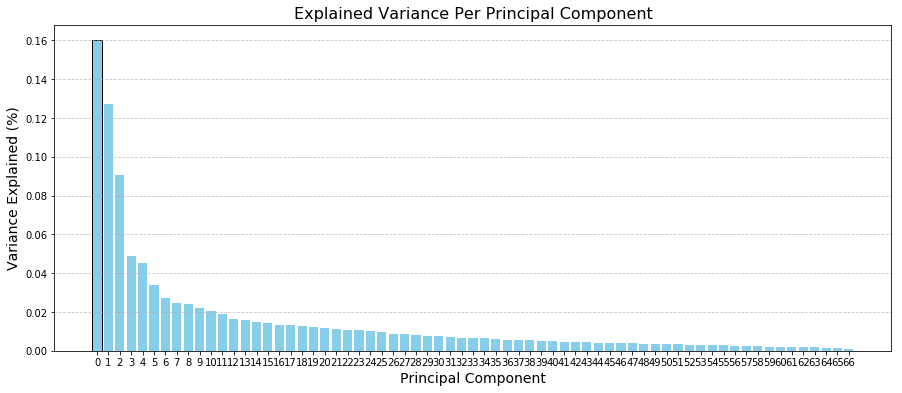

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Investigate the variance accounted for by each principal component
def plot_explained_variance(pca):
    components = np.arange(pca.n_components_)
    exp_variance = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15, 6))
    plt.bar(components, exp_variance, color='skyblue', edgecolor='black')
    plt.xlabel("Principal Component", fontsize=14)
    plt.ylabel("Variance Explained (%)", fontsize=14)
    plt.title("Explained Variance Per Principal Component", fontsize=16)
    plt.xticks(components)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the plotting function with the fitted PCA
plot_explained_variance(pca)

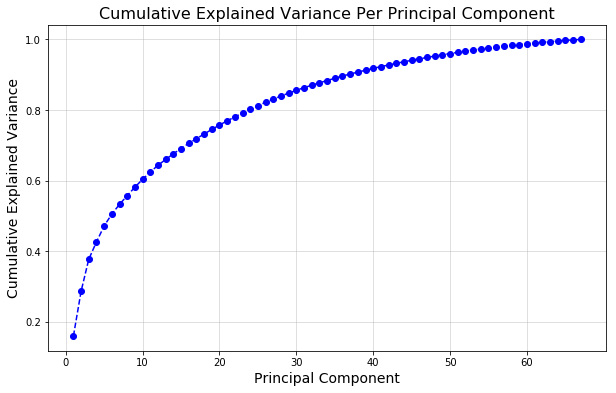

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Calculate cumulative explained variance
cum_vals = np.cumsum(explained_var)

# Generate component indices
components = np.arange(1, len(explained_var) + 1)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(components, cum_vals, marker='o', linestyle='--', color='b')
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Cumulative Explained Variance", fontsize=14)
plt.title("Cumulative Explained Variance Per Principal Component", fontsize=16)
plt.grid(alpha=0.5)

# Customize x-axis ticks to show every 10th component
plt.xticks(np.arange(0, len(explained_var) + 1, 10))  # Show ticks at intervals of 10

plt.show()

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Re-apply PCA with 30 components
pca_30 = do_pca(30, numeric_features_scaled)

# Transform the data using the PCA model with 30 components
data_pca = pca_30.transform(numeric_features_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

After applying PCA and visualizing the results, I decided to retain 30 principal components for the next step of the analysis. This choice allows us to preserve approximately 90% of the variance in the data while significantly reducing its dimensionality.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Define a reusable function to map and sort feature weights 
def interpret_principal_component(pca_model, feature_names, component_index):
    """
    Maps feature weights for the specified principal component to feature names,
    sorts them by magnitude, and prints the results.

    :param pca_model: Fitted PCA model
    :param feature_names: List of feature names
    :param component_index: Index of the principal component (0-based)
    """
    # Extract weights for the specified component
    component_weights = pca_model.components_[component_index]
    
    # Pair weights with feature names
    feature_weights = zip(feature_names, component_weights)
    
    # Sort by absolute weight (magnitude) in descending order
    sorted_features = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)
    
    # Print sorted weights
    print(f"Principal Component {component_index + 1} Feature Weights:")
    for feature, weight in sorted_features:
        print(f"{feature}: {weight:.4f}")

In [60]:
# List of feature names
feature_names = numeric_features_scaled.columns
# Map weights for the first principal component to corresponding feature names
# Analyze the first principal component
interpret_principal_component(pca, feature_names, component_index=0)

Principal Component 1 Feature Weights:
FINANZ_SPARER: 0.2350
FINANZ_MINIMALIST: -0.2337
DECADE: 0.2061
FINANZ_VORSORGER: -0.1974
SEMIO_PFLICHT: 0.1933
SEMIO_REL: 0.1920
ALTERSKATEGORIE_GROB: -0.1901
LP_STATUS_FEIN: -0.1828
MOBI_REGIO: -0.1784
FINANZ_UNAUFFAELLIGER: 0.1782
FINANZ_ANLEGER: 0.1667
PLZ8_ANTG1: -0.1639
KBA05_ANTG1: -0.1610
SEMIO_RAT: 0.1605
GEBURTSJAHR: 0.1575
EWDICHTE: 0.1558
KBA05_GBZ: -0.1542
SEMIO_TRADV: 0.1522
SEMIO_ERL: -0.1412
ORTSGR_KLS9: 0.1394
KONSUMNAEHE: -0.1389
PLZ8_ANTG3: 0.1367
PLZ8_BAUMAX: 0.1341
ZABEOTYP: 0.1296
SEMIO_MAT: 0.1273
PLZ8_ANTG2: 0.1262
LP_LEBENSPHASE_FEIN: -0.1234
ALTER_HH: 0.1232
SEMIO_FAM: 0.1220
PLZ8_GBZ: -0.1217
SEMIO_LUST: -0.1212
INNENSTADT: -0.1128
ARBEIT: 0.1127
HH_EINKOMMEN_SCORE: 0.1123
FINANZTYP: -0.1075
CJT_GESAMTTYP: 0.1069
FINANZ_HAUSBAUER: 0.1016
SEMIO_KULT: 0.0984
MOVEMENT: 0.0978
RELAT_AB: 0.0936
RETOURTYP_BK_S: -0.0858
ANZ_HAUSHALTE_AKTIV: 0.0807
GEBAEUDETYP_RASTER: -0.0794
HEALTH_TYP: 0.0791
WOHNLAGE: -0.0727
SEMIO_VERT: -0.0

In [61]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_principal_component(pca, feature_names, component_index=1)

Principal Component 2 Feature Weights:
ORTSGR_KLS9: 0.1869
PLZ8_ANTG1: -0.1855
PLZ8_BAUMAX: 0.1829
FINANZ_HAUSBAUER: 0.1817
DECADE: -0.1774
KBA05_GBZ: -0.1727
FINANZ_UNAUFFAELLIGER: -0.1663
ALTERSKATEGORIE_GROB: 0.1651
EWDICHTE: 0.1639
FINANZ_ANLEGER: -0.1632
FINANZ_VORSORGER: 0.1628
SEMIO_REL: -0.1626
PLZ8_ANTG3: 0.1604
SEMIO_ERL: 0.1590
SEMIO_TRADV: -0.1589
INNENSTADT: -0.1560
ONLINE_AFFINITAET: -0.1543
GEBURTSJAHR: -0.1531
ALTER_HH: -0.1524
FINANZ_SPARER: -0.1517
LP_STATUS_FEIN: -0.1513
SEMIO_PFLICHT: -0.1508
PLZ8_ANTG2: 0.1474
MOBI_REGIO: -0.1464
RETOURTYP_BK_S: 0.1450
PLZ8_GBZ: -0.1428
SEMIO_KULT: -0.1421
HH_EINKOMMEN_SCORE: 0.1391
KBA05_ANTG1: -0.1372
RELAT_AB: 0.1284
KONSUMNAEHE: -0.1266
SEMIO_LUST: 0.1259
BALLRAUM: -0.1256
W_KEIT_KIND_HH: 0.1230
ARBEIT: 0.1225
ANZ_HAUSHALTE_AKTIV: 0.1197
SEMIO_FAM: -0.1170
SEMIO_RAT: -0.1140
SEMIO_MAT: -0.1047
GEBAEUDETYP_RASTER: -0.1015
LP_LEBENSPHASE_FEIN: -0.0993
ANZ_PERSONEN: -0.0991
WOHNLAGE: -0.0957
SEMIO_KAEM: 0.0927
CJT_GESAMTTYP: -0.08

In [62]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

interpret_principal_component(pca, feature_names, component_index=2)

Principal Component 3 Feature Weights:
ANREDE_KZ: -0.3457
SEMIO_KAEM: -0.3452
SEMIO_VERT: 0.3405
SEMIO_DOM: -0.3195
SEMIO_KRIT: -0.3050
SEMIO_KULT: 0.2945
SEMIO_SOZ: 0.2933
SEMIO_FAM: 0.2413
SEMIO_ERL: -0.1915
FINANZ_ANLEGER: -0.1595
SEMIO_RAT: -0.1457
PLZ8_BAUMAX: 0.0969
KBA13_ANZAHL_PKW: -0.0955
FINANZ_MINIMALIST: 0.0888
FINANZ_UNAUFFAELLIGER: -0.0876
SEMIO_MAT: 0.0867
SHOPPER_TYP: -0.0781
SEMIO_REL: 0.0774
FINANZTYP: 0.0768
BALLRAUM: -0.0767
DECADE: -0.0716
ORTSGR_KLS9: 0.0708
RETOURTYP_BK_S: 0.0698
INNENSTADT: -0.0689
PLZ8_ANTG1: -0.0617
HH_EINKOMMEN_SCORE: 0.0617
PLZ8_ANTG3: 0.0602
GEBAEUDETYP_RASTER: -0.0563
ANZ_HAUSHALTE_AKTIV: 0.0551
FINANZ_SPARER: -0.0535
HEALTH_TYP: -0.0523
PLZ8_GBZ: -0.0517
ALTER_HH: -0.0492
GEBAEUDETYP: 0.0484
RELAT_AB: 0.0460
PLZ8_ANTG2: 0.0447
KBA05_GBZ: -0.0430
VERS_TYP: -0.0399
CJT_GESAMTTYP: -0.0385
MOVEMENT: -0.0378
KBA05_ANTG2: 0.0366
FINANZ_VORSORGER: 0.0357
REGIOTYP: -0.0287
GEBURTSJAHR: -0.0275
FINANZ_HAUSBAUER: -0.0233
PLZ8_HHZ: 0.0222
W_KEIT_KIN

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Looking at FINANZ_SPARER, FINANZ_MINIMALIST, and DECADE, we can see that they have a moderate positive value on Principal Component 1 (PC1). On PC2 and PC3, their values are relatively small, suggesting that these features do not vary much along those dimensions. This indicates that they are most influential in the first principal component.

In Principal Component 1, features like FINANZ_VORSORGER and SEMIO_PFLICHT have a moderate negative value. The values for these features on PC2 and PC3 are also small, suggesting limited variation along these components.

Looking at PLZ8_ANTG1, KBA05_ANTG1, and SEMIO_REL, we see that they have a moderate negative value on PC2, but their values on PC1 and PC3 are quite small. This indicates that these features contribute more to PC2 and have a weaker influence on PC1 and PC3.

In Principal Component 3 (PC3), ANREDE_KZ, SEMIO_KAEM, and SEMIO_VERT show strong weights, with ANREDE_KZ and SEMIO_KAEM having negative values, while SEMIO_VERT has a positive weight. These features are strongly influential in PC3, with SEMIO_KAEM and ANREDE_KZ exhibiting negative associations and SEMIO_VERT showing a positive one. The remaining features in PC3, such as SEMIO_SOZ and SEMIO_KULT, also show moderate positive contributions.

Newly created features, such as those derived from SEMIO_ categories* and FINANZ_ categories*, generally show moderate values in PC1 and PC2. Features like Wealth appear to have a slight negative influence, while others like Finanzsparer and Finanzminimalist have a moderate positive influence in PC1. The newly engineered features do not show significant variation across all components, implying they may not provide as much additional explanatory power as the original features.

This suggests that the FINANZ_ (financial categories)* features and SEMIO_ (semiotic categories)* are most influential in PC1, with strong positive and negative correlations, while features related to geographic regions (PLZ8_ and KBA05_ categories**) appear to play a more prominent role in PC2. Finally, SEMIO_* features have a considerable impact on PC3, with some features displaying strong positive and negative associations.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
 

In [ ]:
from sklearn.cluster import KMeans

scores = []
centers = list(range(2, 21, 2))

# Over a number of different cluster counts...
for center in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    kmeans.fit(pca_data)
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(pca_data))
    scores.append(score)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Number of clusters to evaluate
num_of_clusters = np.arange(2, 30)  
scores = []

# Perform KMeans clustering for each cluster count
for num in num_of_clusters:
    # Run k-means clustering on the PCA-transformed data
    kmeans = KMeans(n_clusters=num, random_state=42)
    model = kmeans.fit(pca_data)
    
    # Compute the average within-cluster distances (negative inertia)
    score = np.abs(model.score(pca_data))  # Use np.abs to get positive values
    scores.append(score)

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE')
plt.title("Number of clusters (K) vs. SSE");

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=16)
kmeans = kmeans.fit(pca_data)
general_preds = kmeans.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';');

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [63]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,KBA05_ANTG1,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,WEALTH,LIFE_TYPOLGY
0,4,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1.0,20.0,10.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,1.0,3,10.0,2.0,1.0,6.0,9.0,1.0,1.0,5.0,1992.0,W,7.0,1,1A,2.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,1.0,5.0,5.0,1.0,2.0,1.0,0.0,1,3
1,4,1,NaN,5,1,5,1,3,2,2,NaN,NaN,1.0,NaN,NaN,1.0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,1.0,3,11.0,3.0,NaN,NaN,9.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,2,2.0,5,1,5,1,4,4,2,NaN,3.0,2.0,13.0,10.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,2.0,3,6.0,1.0,1.0,6.0,9.0,1.0,8.0,1.0,1992.0,W,2.0,5,5D,2.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,5.0,3.0,0.0,3,4
3,4,1,2.0,5,1,5,2,1,2,6,NaN,10.0,2.0,NaN,9.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,NaN,1.0,1,8.0,NaN,4.0,NaN,9.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,3.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,1.0,3.0,4.0,1.0,3.0,1.0,1.0,2,4
4,3,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,3.0,31.0,1.0,1.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,2.0,1,20.0,4.0,6.0,2.0,9.0,7.0,3.0,1.0,1992.0,W,3.0,7,7B,NaN,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,2.0,3.0,3.0,3.0,5.0,1.0,1.0,4,1


In [61]:
#feature transformation, pca
customers_scaled = scaler.transform(customers_prepared.values)
customers_pca = pca_40.transform(customers_scaled)

#customers_scaled
customers_predicted = model_15.predict(customers_pca)

In [ ]:
# scalling 
customers_scaled = scaler.transform(customers_cleaned)
customers_scaled = pd.DataFrame(customers_scaled, columns=customers_cleaned.columns)

# PCA transformation
customers_pca = pca.transform(customers_scaled)

# kmeans prediction
customers_preds = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.